# Notebook d'inférence : AConvNet


## Importation des librairies

In [20]:
import numpy as np

import json
import glob
import sys
import os

from tqdm import tqdm
import torchvision
import torch

sys.path.append('../src')
from data.MSTAR.paper_AConvNet import preprocess # type: ignore
from data.MSTAR.paper_AConvNet import loader # type: ignore
from data.MSTAR.Felipe import process_mstar_AConvNet # type: ignore
from utils import common # type: ignore
from models.AConvNet.network import AConvNet # type: ignore
from models._base import Model # type: ignore

from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

## Choix de l'expérience

In [2]:
experiment_path = "SOC_AConvNet_1"

## Visualisation de l'entraînement

In [3]:
with open(f'./{experiment_path}/history-AConvNet-SOC.json') as f:
    history = json.load(f)

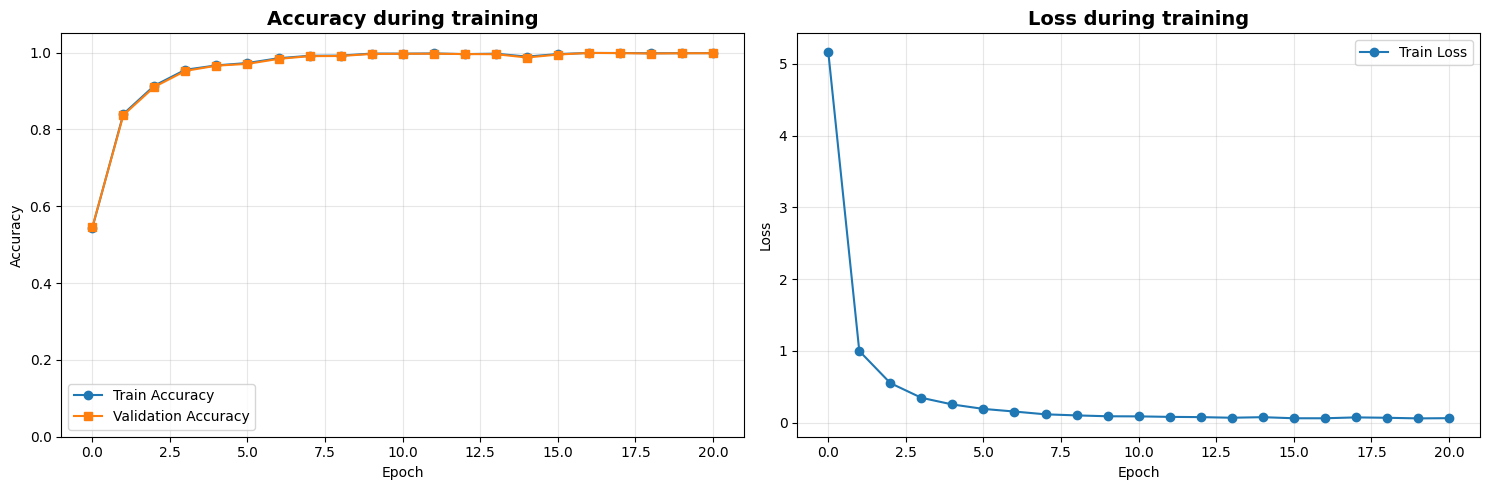

RÉSUMÉ DE L'ENTRAÎNEMENT

 MÉTRIQUES FINALES :
   Train Accuracy      : 99.8477 (9984.77%)
   Validation Accuracy : 99.8217 (9982.17%)
   Train Loss          : 0.063771

 MEILLEURS RÉSULTATS:
   Meilleure Val Accuracy : 99.9034 (9990.34%) à l'epoch 17

 CONVERGENCE:
   Epoch 1 → Epoch finale:
   - Train Accuracy: 54.3489 → 99.8477
   - Val Accuracy  : 54.5002 → 99.8217


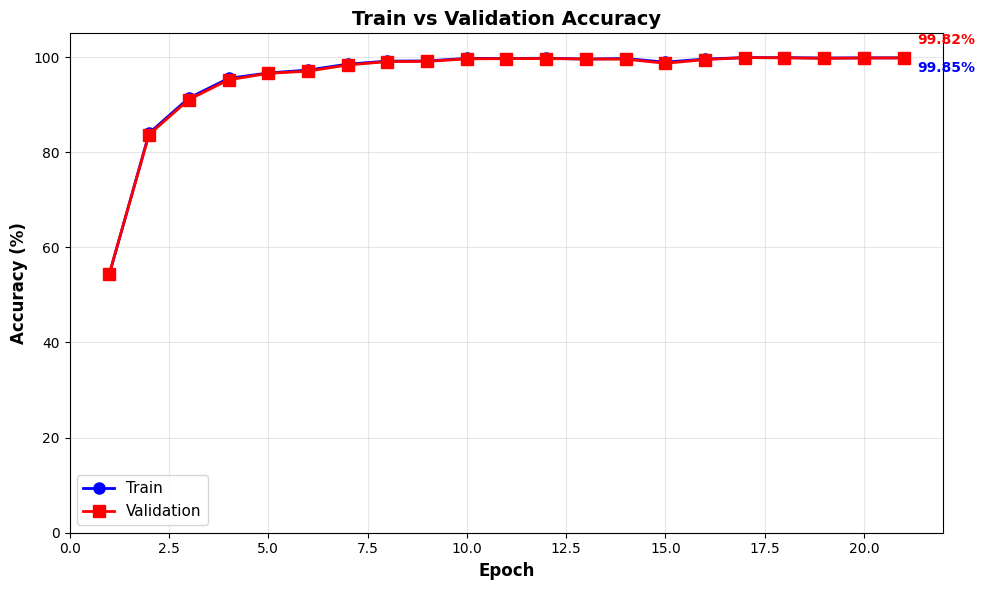

In [4]:
training_loss = history['train_loss']
training_accuracy = history['train_accuracy']
validation_accuracy = history['val_accuracy']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(np.array(training_accuracy) / 100, label='Train Accuracy', marker='o')
axes[0].plot(np.array(validation_accuracy) / 100, label='Validation Accuracy', marker='s')
axes[0].set_title('Accuracy during training', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1.05])

# Loss
axes[1].plot(training_loss, label='Train Loss', marker='o')
axes[1].set_title('Loss during training', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 70)
print("RÉSUMÉ DE L'ENTRAÎNEMENT")
print("=" * 70)

# Métriques finales
final_train_acc = training_accuracy[-1]
final_val_acc = validation_accuracy[-1]
final_train_loss = training_loss[-1]

print(f"\n MÉTRIQUES FINALES :")
print(f"   Train Accuracy      : {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"   Validation Accuracy : {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"   Train Loss          : {final_train_loss:.6f}")

# Métriques maximales
max_val_acc = max(validation_accuracy)
max_val_acc_epoch = validation_accuracy.index(max_val_acc) + 1

print(f"\n MEILLEURS RÉSULTATS:")
print(f"   Meilleure Val Accuracy : {max_val_acc:.4f} ({max_val_acc*100:.2f}%) à l'epoch {max_val_acc_epoch}")

# Convergence
print(f"\n CONVERGENCE:")
print(f"   Epoch 1 → Epoch finale:")
print(f"   - Train Accuracy: {training_accuracy[0]:.4f} → {final_train_acc:.4f}")
print(f"   - Val Accuracy  : {validation_accuracy[0]:.4f} → {final_val_acc:.4f}")

print("=" * 70)

fig, ax = plt.subplots(figsize=(10, 6))

epochs = range(1, len(training_accuracy) + 1)
train_acc = np.array(training_accuracy)
val_acc = np.array(validation_accuracy)

ax.plot(epochs, train_acc, 'b-o', label='Train', linewidth=2, markersize=8)
ax.plot(epochs, val_acc, 'r-s', label='Validation', linewidth=2, markersize=8)
ax.fill_between(epochs, train_acc, val_acc, alpha=0.2, color='gray')

ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Train vs Validation Accuracy', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 105])

# Annoter le dernier point
ax.annotate(f'{train_acc[-1]:.2f}%',
            xy=(epochs[-1], train_acc[-1]),
            xytext=(10, -10),
            textcoords='offset points',
            fontweight='bold',
            color='blue')
ax.annotate(f'{val_acc[-1]:.2f}%',
            xy=(epochs[-1], val_acc[-1]),
            xytext=(10, 10),
            textcoords='offset points',
            fontweight='bold',
            color='red')

plt.tight_layout()
plt.show()

## Évaluation sur test set

In [13]:
# load test data and run inference on test data
def load_dataset(path, is_train, name, batch_size):

    _dataset = loader.Dataset(
        path, name=name, is_train=is_train,
        transform=torchvision.transforms.Compose([
            preprocess.CenterCrop(94),
        ])
    )
    data_loader = torch.utils.data.DataLoader(
        _dataset, batch_size=batch_size, shuffle=is_train, num_workers=0
    )
    return data_loader


def evaluate(_m, ds):
    
    num_data = 0
    corrects = 0
    
    _m.net.eval()
    _softmax = torch.nn.Softmax(dim=1)
    for i, data in enumerate(ds):
        images, labels, _ = data

        predictions = _m.inference(images)
        predictions = _softmax(predictions)

        _, predictions = torch.max(predictions.data, 1)
        labels = labels.type(torch.LongTensor)
        num_data += labels.size(0)
        corrects += (predictions == labels.to(_m.device)).sum().item()

    accuracy = 100 * corrects / num_data
    return accuracy

In [16]:
# print config
with open(f'./{experiment_path}/AConvNet-SOC.json') as f:
    config = json.load(f)

model_name = config['model_name']
model_str = 'AConvNet'
dataset_path = 'datasets/MSTAR/MSTAR_IMG_JSON'

test_set = load_dataset(dataset_path, False, config['dataset'], 10)

net = AConvNet(
        classes=config['num_classes'],
        channels=config['channels'],
        dropout_rate=config['dropout_rate']
    )

m = Model(
    net=net,
    lr=config['lr'], 
    lr_step=config['lr_step'],
    lr_decay=config['lr_decay'],
    weight_decay=config['weight_decay'],
    criterion=torch.nn.CrossEntropyLoss(),
)

# model_history = glob.glob(os.path.join(common.project_root, f'experiments/{model_str}/model/{model_name}/*.pth'))
model_history = glob.glob(os.path.join(common.project_root, f'notebooks/SOC_AConvNet_1/*.pth'))
model_history = sorted(model_history, key=os.path.basename)

best = {
    'epoch': 0,
    'accuracy': 0,
    'path': ''
}

for i, model_path in enumerate(model_history):
    m.load(model_path)
    accuracy = evaluate(m, test_set)
    if accuracy > best['accuracy']:
        best['epoch'] = i
        best['accuracy'] = accuracy
        best['path'] = model_path
        print(f'Best accuracy at epoch={i} with {accuracy:.2f}%')
    
best_epoch = best['epoch']
best_accuracy = best['accuracy']
best_path = best['path']

print(f'Final model is epoch={best_epoch} with accurayc={best_accuracy:.2f}%')
print(f'Path={best_path}')


load test data set:   0%|          | 0/2425 [00:00<?, ?it/s]

load test data set: 100%|██████████| 2425/2425 [00:00<00:00, 3841.75it/s]


Device used: cpu
Best accuracy at epoch=0 with 55.55%
Best accuracy at epoch=1 with 82.52%
Best accuracy at epoch=2 with 89.03%
Best accuracy at epoch=3 with 90.89%
Best accuracy at epoch=5 with 90.93%
Best accuracy at epoch=6 with 93.07%
Best accuracy at epoch=7 with 95.42%
Best accuracy at epoch=8 with 95.92%
Best accuracy at epoch=9 with 96.12%
Best accuracy at epoch=19 with 96.58%
Best accuracy at epoch=20 with 97.53%
Final model is epoch=20 with accurayc=97.53%
Path=/home/mqtho/ATR-Code/notebooks/SOC_AConvNet_1/model-021.pth


In [ ]:
def confusion_matrix(_m, ds):
    _pred = []
    _gt = []
    
    _m.net.eval()
    _softmax = torch.nn.Softmax(dim=1)
    for i, data in enumerate(ds):
        images, labels, _ = data
        
        predictions = _m.inference(images)
        predictions = _softmax(predictions)

        _, predictions = torch.max(predictions.data, 1)
        labels = labels.type(torch.LongTensor)
        
        _pred += predictions.cpu().tolist()
        _gt += labels.cpu().tolist()
        
    conf_mat = metrics.confusion_matrix(_gt, _pred)

    return conf_mat

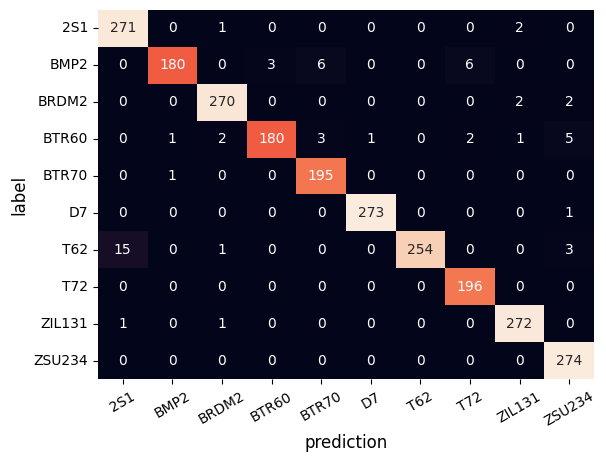

In [ ]:
m.load(best_path)
_conf_mat = confusion_matrix(m, test_set)

sns.reset_defaults()
ax = sns.heatmap(_conf_mat, annot=True, fmt='d', cbar=False)
ax.set_yticklabels(process_mstar_AConvNet.target_name_soc, rotation=0)
ax.set_xticklabels(process_mstar_AConvNet.target_name_soc, rotation=30)

plt.xlabel('prediction', fontsize=12)
plt.ylabel('label', fontsize=12)

plt.show()